In [31]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Wrapper, Dense, Dropout, Lambda, Layer
from keras import layers as KL
from keras.optimizers import RMSprop, Adam
from keras.engine import InputSpec

from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
from functools import partial

# Load data and set parameters

In [24]:
batch_size = 128
num_classes = 10
epochs = 5

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = (x_train / 255.0)*2 - 1
x_test = (x_test/255.0)*2 - 1
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


In [25]:
def plot_digits(data, title="", show_title=False):
    plt.figure(figsize=(16,2))
    data = data.reshape(-1, 28, 28)
    for i in range(np.min([data.shape[0],16])):
        plt.subplot(1,16, i+1)
        plt.imshow(data[i,:,:], cmap='Reds')
        plt.xticks([])
        plt.yticks([])
    if show_title:
        plt.suptitle(title)
    plt.show()

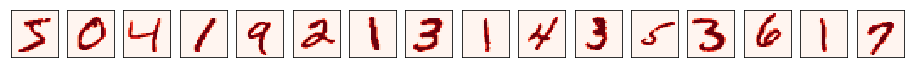

In [26]:
plot_digits(x_train[:20,:])

# Define LRP Layer and function

In [27]:
DIVISION_ADJUSTMENT = 0.0001

def zplus_rule(args):
    x, w, rel = args
    v = K.maximum(0.0, w)

    z = K.dot(x, v) + DIVISION_ADJUSTMENT
    s = rel / z
    c = K.dot(s, K.transpose(v))
    return c

def beta_rule(args, lowest=-1, highest=1):
    x, w, rel = args
    w, v, u = w, K.maximum(0.0, w), K.minimum(0.0, w)
    l, h = x * 0 + lowest, x * 0 + highest

    z = K.dot(x, w) - (K.dot(l, v) + K.dot(h, u)) + DIVISION_ADJUSTMENT
    s = rel / z
    return x * K.dot(s, K.transpose(w))\
           - (l * K.dot(s, K.transpose(v)) + h * K.dot(s, K.transpose(u))) 
    
def lrp_rule(name, **kargs):
    if name == 'zplus':
        return partial(zplus_rule)
    elif name == 'beta':
        return partial(beta_rule, **kargs)

class LRPDense(Dense):
    def __init__(self, *args, **kwargs):
        self.lrp_rule = kwargs['lrp_rule']
        del kwargs['lrp_rule']
        super(LRPDense, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        super(LRPDense, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        output = super(LRPDense, self).call(x)        
        return output

    def compute_output_shape(self, input_shape):
        return super(LRPDense, self).compute_output_shape(input_shape)
    
    def rel_prop(self, x, relevance):
        output = Lambda(self.lrp_rule, output_shape=lambda s: s)([x, self.kernel, relevance])        

        setattr(output, '_keras_history', (self, 0, 0))
        return output
    
class LRPDoNothingLayer(Wrapper):

    def __init__(self, layer, **kwargs):
        super(LRPDummyLayer, self).__init__(layer, **kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        self.input_spec = InputSpec(shape=input_shape)
        child_input_shape = (input_shape[0],) + input_shape[2:]
        if not self.layer.built:
            self.layer.build(child_input_shape)
            self.layer.built = True
        super(LRPDummyLayer, self).build(input_shape)  # Be sure to call this somewhere!
        
    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def call(self, x): 
        return self.layer.call(x)

    
    def rel_prop(self, x, relevance):
        return relevance
    
    

In [47]:
model2 = Sequential()
model2.add(LRPDense(512, lrp_rule=lrp_rule('beta', lowest=-1, highest=1), activation='relu', input_shape=(784,)))
model2.add(LRPDummyLayer(Dropout(0.5)))
model2.add(LRPDense(256, lrp_rule=lrp_rule('zplus'), activation='relu'))
model2.add(LRPDummyLayer(Dropout(0.5)))
model2.add(LRPDense(128, lrp_rule=lrp_rule('zplus'), activation='relu'))
model2.add(LRPDense(num_classes, lrp_rule=lrp_rule('zplus'), activation='softmax'))

model2.summary()

model2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lrp_dense_37 (LRPDense)      (None, 512)               401920    
_________________________________________________________________
lrp_dummy_layer_19 (LRPDummy (None, 512)               0         
_________________________________________________________________
lrp_dense_38 (LRPDense)      (None, 256)               131328    
_________________________________________________________________
lrp_dummy_layer_20 (LRPDummy (None, 256)               0         
_________________________________________________________________
lrp_dense_39 (LRPDense)      (None, 128)               32896     
_________________________________________________________________
lrp_dense_40 (LRPDense)      (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________


In [48]:

history = model2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=50,
                    verbose=0,
                    validation_data=(x_test, y_test))
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.104459303464
Test accuracy: 0.977


In [44]:
def explain(model):
    layers = model.layers

    outputs = [model.input] + [ l.output for l in layers ]
    relevances = [None]*(len(outputs))
    relevances[-1] = layers[-1].output

    for i in range(-1, -len(layers)-1, -1):
        relevances[i-1] = layers[i].rel_prop(outputs[i-1], relevances[i])

    return relevances

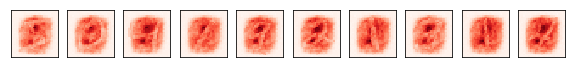

In [49]:
heatmap = explain(model2)
viz = Model(inputs=model2.input, outputs=heatmap[0])
h = viz.predict(x_train[:10,:])
plot_digits(h)


In [ ]:
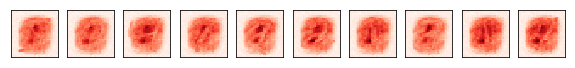

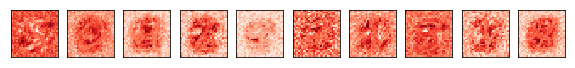

In [38]:
heatmap = explain(model2)
viz = Model(inputs=model2.input, outputs=heatmap[0])
h = viz.predict(x_train[:10,:])
plot_digits(h)

In [106]:
model = Sequential()
model.add(LRPDense(512, lrp_rule=lrp_rule('beta', lowest=0, highest=1), activation='relu', input_shape=(784,)))
# model.add(Dropout(0.2))
model.add(LRPDense(512, lrp_rule=lrp_rule('zplus'), activation='relu'))
# model.add(Dropout(0.2))
model.add(LRPDense(num_classes, lrp_rule=lrp_rule('zplus'), activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lrp_dense_38 (LRPDense)      (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
lrp_dense_39 (LRPDense)      (None, 512)               262656    
_________________________________________________________________
lrp_dense_40 (LRPDense)      (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [97]:
def explain(model):
    layers = model.layers

    outputs = [model.input] + [ l.output for l in layers ]
    relevances = [None]*(len(outputs))
    relevances[-1] = layers[-1].output

    for i in range(-1, -len(layers)-1, -1):
        relevances[i-1] = layers[i].rel_prop(outputs[i-1], relevances[i])

    return relevances

heatmap = explain(model)
heatmap

[<tf.Tensor 'lambda_27/sub_1:0' shape=(?, 784) dtype=float32>,
 <tf.Tensor 'lambda_26/MatMul_1:0' shape=(?, 512) dtype=float32>,
 <tf.Tensor 'lambda_25/MatMul_1:0' shape=(?, 512) dtype=float32>,
 <tf.Tensor 'lrp_dense_33/Softmax:0' shape=(?, 10) dtype=float32>]

In [98]:
# vis = Model(inputs=model.input, outputs=heatmap.ouptu)
viz = Model(inputs=model.input, outputs=heatmap[0])

In [99]:
h = viz.predict(x_train[:10,:])

In [100]:
h.shape

(10, 784)

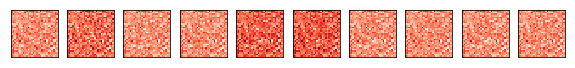

In [101]:
heatmap = explain(model)
viz = Model(inputs=model.input, outputs=heatmap[0])
h = viz.predict(x_train[:10,:])
plot_digits(h)

In [75]:

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 91us/step - loss: 0.2164 - acc: 0.9334 - val_loss: 0.0930 - val_acc: 0.9713
Epoch 2/20
60000/60000 [==============================] - 5s 84us/step - loss: 0.0820 - acc: 0.9751 - val_loss: 0.0898 - val_acc: 0.9734
Epoch 3/20
60000/60000 [==============================] - 5s 85us/step - loss: 0.0537 - acc: 0.9840 - val_loss: 0.0714 - val_acc: 0.9798
Epoch 4/20
60000/60000 [==============================] - 6s 95us/step - loss: 0.0388 - acc: 0.9880 - val_loss: 0.0698 - val_acc: 0.9799
Epoch 5/20
60000/60000 [==============================] - 6s 93us/step - loss: 0.0300 - acc: 0.9906 - val_loss: 0.0866 - val_acc: 0.9793
Epoch 6/20
60000/60000 [==============================] - 6s 96us/step - loss: 0.0230 - acc: 0.9926 - val_loss: 0.0853 - val_acc: 0.9806
Epoch 7/20
60000/60000 [==============================] - 6s 96us/step - loss: 0.0189 - acc: 0.9940 - val_loss: 0.0851 - val_acc

In [99]:
viz_model = Model(inputs=model.input, outputs=heatmap)

TypeError: Output tensors to a Model must be Keras tensors. Found: Tensor("sub_1:0", shape=(?, 784), dtype=float32)

In [98]:
viz_model.predict(x_train[:5,:])

array([[ 0.11384565,  0.09688398,  0.08379211,  0.11497436,  0.09848945,
         0.08834918,  0.14573166,  0.05893434,  0.10097259,  0.09802666],
       [ 0.10312912,  0.09936639,  0.08958689,  0.10862304,  0.09725285,
         0.10144849,  0.0846601 ,  0.05637852,  0.12093848,  0.1386161 ],
       [ 0.09255937,  0.10434079,  0.06701206,  0.14013456,  0.09003647,
         0.08171756,  0.11649356,  0.05378961,  0.11928923,  0.13462685],
       [ 0.12125329,  0.12312869,  0.07909529,  0.11854502,  0.07500505,
         0.09595336,  0.10659783,  0.07797137,  0.0812717 ,  0.12117846],
       [ 0.11129158,  0.0960509 ,  0.0758284 ,  0.11121193,  0.08253022,
         0.08595848,  0.1358384 ,  0.07327467,  0.11887516,  0.10914025]], dtype=float32)

In [94]:
model.output

<tf.Tensor 'lrp_dense_26/Softmax:0' shape=(?, 10) dtype=float32>

In [96]:
heatmap

<tf.Tensor 'sub_1:0' shape=(?, 784) dtype=float32>

In [101]:
model.output._keras_history

(LRPDense-zplus, 0, 0)

In [102]:
heatmap._keras_history

AttributeError: 'Tensor' object has no attribute '_keras_history'

In [104]:
K.eval(heatmap, feed_dict={ model.input : x_train[:5, :]})

TypeError: eval() got an unexpected keyword argument 'feed_dict'